# дефол

In [1]:
# Сделаем необходимые импорты
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import optim
from IPython.display import clear_output
import time

In [2]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него

train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True,)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 60449480.64it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [3]:
# Создаем класс для нашей архитектуры и наследуем его от nn.Module
class Net(nn.Module):
    # Определяем входной, скрытый и выходной слои с помощью линейных слоев nn.Linear()
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    # Каждый следующий слой использует выход предыдущего слоя как вход
    # Функция активации - LeakyReLU
    def forward(self, x):
        x = x.view(x.shape[0], -1) # reshape
        x = self.fc1(x)            # внутренний полносвязный линейный слой
        x = F.leaky_relu(x)        # функция активации
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        return x                   # Возвращаем выход последнего слоя -> подсчет ошибки

    # Добавляем метод predict для получения предсказания на основе выхода последнего слоя с применением функции Softmax
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.softmax(x)           # Предсказание - вероятность класса
        return x

def get_model(net = Net(3072, 100, 10), t_o = 12, show_the_learning_process = 0):
  # Устанавливаем режим обучения
  net.train()

  # Определяем критерий (функцию потерь) - многоклассовую перекрестную энтропию
  criterion = nn.CrossEntropyLoss()   #  много-классовая перекрестная кросс-энтропия

  # Список оптимизаторов
  torch_optimizer = [optim.Adadelta(net.parameters(), lr=0.01),
                     optim.Adagrad(net.parameters(), lr=0.01),
                     optim.Adam(net.parameters(), lr=0.01),
                     optim.AdamW(net.parameters(), lr=0.01),
                     optim.SparseAdam(net.parameters(), lr=0.01),
                     optim.Adamax(net.parameters(), lr=0.01),
                     optim.ASGD(net.parameters(), lr=0.01),
                     optim.LBFGS(net.parameters(), lr=0.01),
                     optim.NAdam(net.parameters(), lr=0.01),
                     optim.RAdam(net.parameters(), lr=0.01),
                     optim.RMSprop(net.parameters(), lr=0.01, momentum=0.0),
                     optim.Rprop(net.parameters(), lr=0.01),
                     optim.SGD(net.parameters(), lr=0.01, momentum=0.0)]

  # Определяем оптимизатор - SGD (стохастический градиентный спуск) с параметрами скорости обучения (lr) 0.01 и моментумом 0.0
  optimizer = torch_optimizer[t_o]

  # Определяем количество эпох обучения (5)
  num_epochs = 5

  # В цикле проходим по обучающей выборке и обновляем веса
  for epoch in range(num_epochs):
      running_loss = 0.0
      running_items = 0.0

      for i, data in enumerate(train_loader):
          inputs, labels = data[0], data[1]

          # Обнуляем градиент перед вычислением лосса и шагом обновления весов
          optimizer.zero_grad()
          # Делаем предсказание
          outputs = net(inputs)
          # Вычисляем лосс-функцию на обучающей выборке
          loss = criterion(outputs, labels)
          # Делаем шаг назад по лоссу
          loss.backward()
          # Считаем градиент для каждого веса в нейронной сети и делаем шаг обновления весов с помощью optimizer.step()
          optimizer.step()

          # выводим статистику о процессе обучения
          running_loss += loss.item()
          running_items += len(labels)

          if show_the_learning_process == 1:
            # Выводим статистику обучения после каждых 300 mini-batches
            if i % 300 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f}')
                running_loss, running_items = 0.0, 0.0
  if show_the_learning_process == 1:
    print('Training is finished!')
  return net

# Вычисляем точность предсказания на обучающей выборке в конце обучения
def check_model(net):
  result = []
  for i, data in enumerate(train_loader):
    inputs, labels = data[0], data[1]
    predicted = torch.max(net(inputs), 1).indices
    result.append(int((predicted == labels).sum())/len(labels))

  # Возвращаем среднюю точность предсказания
  print(f'Средняя точность составляет: {sum(result)/len(result)}')
  return sum(result)/len(result)

Оценка модели из урока

In [4]:
model = get_model(show_the_learning_process=1)
r = check_model(model)

Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.036
Epoch [1/5]. Step [601/782]. Loss: 0.035
Epoch [2/5]. Step [1/782]. Loss: 0.033
Epoch [2/5]. Step [301/782]. Loss: 0.032
Epoch [2/5]. Step [601/782]. Loss: 0.032
Epoch [3/5]. Step [1/782]. Loss: 0.032
Epoch [3/5]. Step [301/782]. Loss: 0.030
Epoch [3/5]. Step [601/782]. Loss: 0.030
Epoch [4/5]. Step [1/782]. Loss: 0.028
Epoch [4/5]. Step [301/782]. Loss: 0.029
Epoch [4/5]. Step [601/782]. Loss: 0.029
Epoch [5/5]. Step [1/782]. Loss: 0.031
Epoch [5/5]. Step [301/782]. Loss: 0.028
Epoch [5/5]. Step [601/782]. Loss: 0.028
Training is finished!
Средняя точность составляет: 0.36514945652173914


# Оптимизатор
Найдем оптимизатор с лучшими результатами

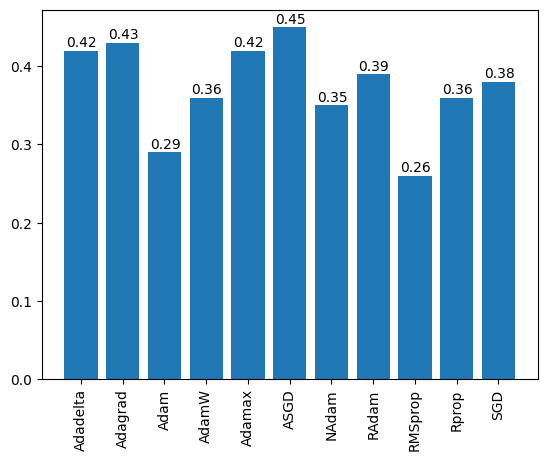

In [5]:
name_optimizer_list = ['Adadelta', 'Adagrad', 'Adam', 'AdamW', 'SparseAdam', 'Adamax', 'ASGD', 'LBFGS', 'NAdam', 'RAdam', 'RMSprop', 'Rprop', 'SGD']
result = []
t = []
for i, name_optimizer in enumerate(name_optimizer_list):
  clear_output(wait=True)
  print(f'Тест {i} из {len(name_optimizer_list)}\nПредпологаемое время ожидания: {round((sum(t)/len(t))*(len(name_optimizer_list)-i)) if len(t) !=0 else "..."}')
  start = time.time()

  try:
    model = get_model(t_o = i)
    result.append([name_optimizer, check_model(model)])
  except Exception as error:
    result.append([name_optimizer, error])

  end = time.time()
  t.append(end-start)

clear_output(wait=True)

x = [value[0] for value in result if type(value[1]) == float]
y = [round(value[1], 2) for value in result if type(value[1]) == float]
plt.bar(x, y)
for index, value in enumerate(y):
    plt.text(index-0.35, value+0.005, str(value))
plt.xticks(rotation=90);

best_optimizer = name_optimizer_list.index(x[np.array(y).argmax()])

# Слои
Попробуем увеличить колличество слоев

In [6]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True,)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def predict(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

model = get_model(net = Net(10), show_the_learning_process=1)
check_model(model)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.036
Epoch [1/5]. Step [601/782]. Loss: 0.036
Epoch [2/5]. Step [1/782]. Loss: 0.036
Epoch [2/5]. Step [301/782]. Loss: 0.036
Epoch [2/5]. Step [601/782]. Loss: 0.036
Epoch [3/5]. Step [1/782]. Loss: 0.036
Epoch [3/5]. Step [301/782]. Loss: 0.036
Epoch [3/5]. Step [601/782]. Loss: 0.036
Epoch [4/5]. Step [1/782]. Loss: 0.035
Epoch [4/5]. Step [301/782]. Loss: 0.035
Epoch [4/5]. Step [601/782]. Loss: 0.033
Epoch [5/5]. Step [1/782]. Loss: 0.032
Epoch [5/5]. Step [301/782]. Loss: 0.032
Epoch [5/5]. Step [601/782]. Loss: 0.032
Training is finished!
Средняя точность составляет: 0.20526294757033248


0.20526294757033248

# Данные
Попробуем теперь разнообразить исходные данные.  
Используемые аугментации:
- случайный кроп
- случайный горизонтальный флип
- случайный поворот на угол до 15 градусов

In [7]:
import torchvision.transforms as transforms
import torch.utils.data as data
import random
from PIL import Image

class RandomResizedCrop:
    def __call__(self, x):
        im_w, im_h = x.size
        scale = random.uniform(0.5, 1.0)
        target_w, target_h = int(im_w * scale), int(im_h * scale)
        x1 = random.randint(0, im_w - target_w)
        y1 = random.randint(0, im_h - target_h)
        x2, y2 = x1 + target_w, y1 + target_h
        return x.crop((x1, y1, x2, y2)).resize((im_w, im_h))

class RandomHorizontalFlip:
    def __call__(self, x):
        if random.random() < 0.5:
            return x.transpose(Image.FLIP_LEFT_RIGHT)
        return x

class RandomRotation:
    def __init__(self, degrees=15):
        self.degrees = degrees

    def __call__(self, x):
        angle = random.uniform(-self.degrees, self.degrees)
        return x.rotate(angle)

train_transform = transforms.Compose([
    RandomResizedCrop(),
    RandomHorizontalFlip(),
    RandomRotation(15),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,
                                             transform=train_transform,
                                             download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            transform=test_transform,
                                            download=True,)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model = get_model(Net(10), best_optimizer, 1)
check_model(model)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.036
Epoch [1/5]. Step [601/782]. Loss: 0.036
Epoch [2/5]. Step [1/782]. Loss: 0.036
Epoch [2/5]. Step [301/782]. Loss: 0.036
Epoch [2/5]. Step [601/782]. Loss: 0.036
Epoch [3/5]. Step [1/782]. Loss: 0.036
Epoch [3/5]. Step [301/782]. Loss: 0.036
Epoch [3/5]. Step [601/782]. Loss: 0.036
Epoch [4/5]. Step [1/782]. Loss: 0.035
Epoch [4/5]. Step [301/782]. Loss: 0.035
Epoch [4/5]. Step [601/782]. Loss: 0.034
Epoch [5/5]. Step [1/782]. Loss: 0.036
Epoch [5/5]. Step [301/782]. Loss: 0.033
Epoch [5/5]. Step [601/782]. Loss: 0.033
Training is finished!
Средняя точность составляет: 0.22194693094629156


0.22194693094629156